## EDA benin

## Import Packages

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from windrose import WindroseAxes
import os

## Load Data

In [8]:
file_path = r'c:\Users\Daniel.Temesgen\Desktop\tutorial\kalm-week-0\solar-challenge-week1\datas\benin-malanville.csv'
df = pd.read_csv(file_path, encoding='utf-8')


In [9]:
df.head()

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-08-09 00:01,-1.2,-0.2,-1.1,0.0,0.0,26.2,93.4,0.0,0.4,0.1,122.1,0.0,998,0,0.0,26.3,26.2,NaN
1,2021-08-09 00:02,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.6,0.0,0.0,0.0,0.0,0.0,998,0,0.0,26.3,26.2,NaN
2,2021-08-09 00:03,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.7,0.3,1.1,0.5,124.6,1.5,997,0,0.0,26.4,26.2,NaN
3,2021-08-09 00:04,-1.1,-0.1,-1.0,0.0,0.0,26.2,93.3,0.2,0.7,0.4,120.3,1.3,997,0,0.0,26.4,26.3,NaN
4,2021-08-09 00:05,-1.0,-0.1,-1.0,0.0,0.0,26.2,93.3,0.1,0.7,0.3,113.2,1.0,997,0,0.0,26.4,26.3,NaN


# 1. Summary Statistics & Missing-Value Report

In [10]:
print("Summary Statistics:")
print(df.describe())
print("\nMissing Values:")
missing = df.isna().sum()
print(missing)
print("\nColumns with >5% Missing:")
missing_pct = (missing / len(df)) * 100
print(missing_pct[missing_pct > 5])

Summary Statistics:
                 GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      240.559452     167.187516     115.358961     236.589496   
std       331.131327     261.710501     158.691074     326.894859   
min       -12.900000      -7.800000     -12.600000       0.000000   
25%        -2.000000      -0.500000      -2.100000       0.000000   
50%         1.800000      -0.100000       1.600000       4.500000   
75%       483.400000     314.200000     216.300000     463.700000   
max      1413.000000     952.300000     759.200000    1342.300000   

                ModB           Tamb             RH             WS  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      228.883576      28.179683      54.487969       2.121113   
std       316.536515       5.924297      28.073069       1.603466   
min         0.000000      11.000000       2.100000       0.000000   
25%         0

# 2. Outlier Detection & Basic Cleaning

In [11]:
key_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# Compute Z-scores

In [12]:
z_scores = df[key_cols].apply(zscore, nan_policy='omit')
outliers = (z_scores.abs() > 3).any(axis=1)
print(f"\nNumber of outlier rows (|Z|>3): {outliers.sum()}")


Number of outlier rows (|Z|>3): 7740


# Handle missing values (impute with median for key columns)

In [13]:
for col in key_cols:
    if df[col].isna().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

# Drop remaining rows with missing values in key columns

In [14]:
df.dropna(subset=key_cols, inplace=True)

# Export cleaned data

In [18]:
os.makedirs('data', exist_ok=True)
df.to_csv('data/benin_clean.csv', index=False)
print("\nCleaned data exported to data/benin_clean.csv")



Cleaned data exported to data/benin_clean.csv


# 3. Time Series Analysis

In [19]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Month'] = df['Timestamp'].dt.month
df['Hour'] = df['Timestamp'].dt.hour

# Plot GHI, DNI, DHI, Tamb over time

<function matplotlib.pyplot.show(close=None, block=None)>

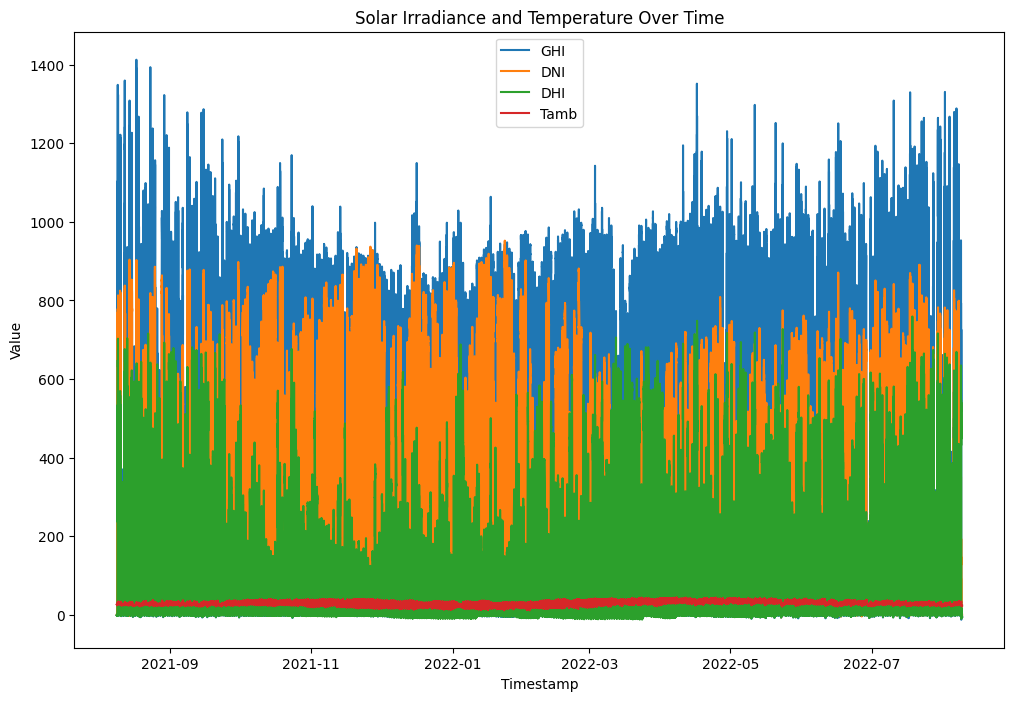

In [21]:
plt.figure(figsize=(12, 8))
for col in ['GHI', 'DNI', 'DHI', 'Tamb']:
    plt.plot(df['Timestamp'], df[col], label=col)
plt.title('Solar Irradiance and Temperature Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show

# Monthly patterns

<function matplotlib.pyplot.show(close=None, block=None)>

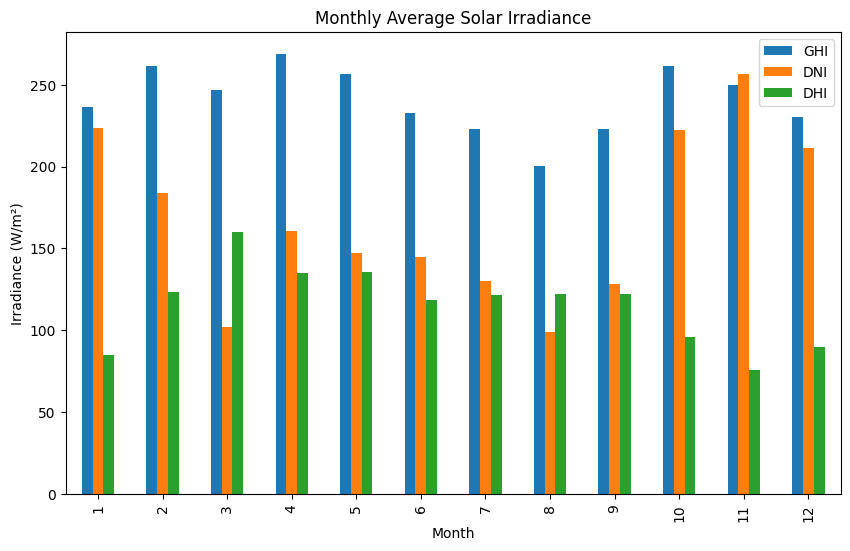

In [23]:
monthly_avg = df.groupby('Month')[['GHI', 'DNI', 'DHI']].mean()
monthly_avg.plot(kind='bar', figsize=(10, 6))
plt.title('Monthly Average Solar Irradiance')
plt.xlabel('Month')
plt.ylabel('Irradiance (W/m²)')
plt.show


# 4. Cleaning Impact

<function matplotlib.pyplot.show(close=None, block=None)>

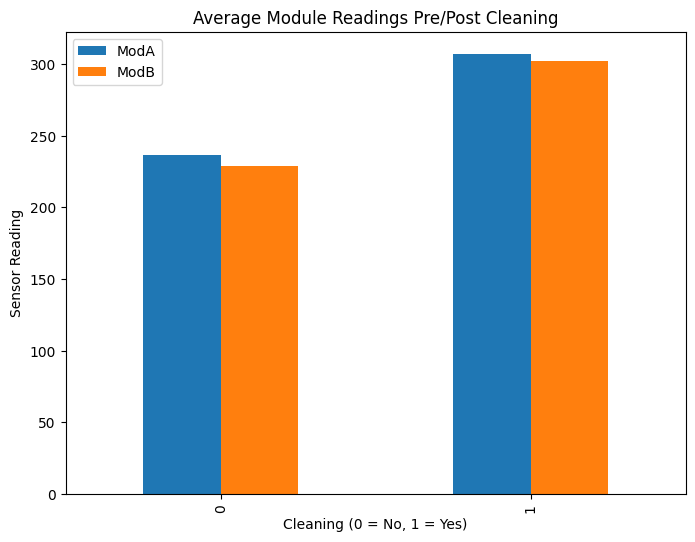

In [24]:
cleaning_impact = df.groupby('Cleaning')[['ModA', 'ModB']].mean()
cleaning_impact.plot(kind='bar', figsize=(8, 6))
plt.title('Average Module Readings Pre/Post Cleaning')
plt.xlabel('Cleaning (0 = No, 1 = Yes)')
plt.ylabel('Sensor Reading')
plt.show


# 5. Correlation & Relationship Analysis

<function matplotlib.pyplot.show(close=None, block=None)>

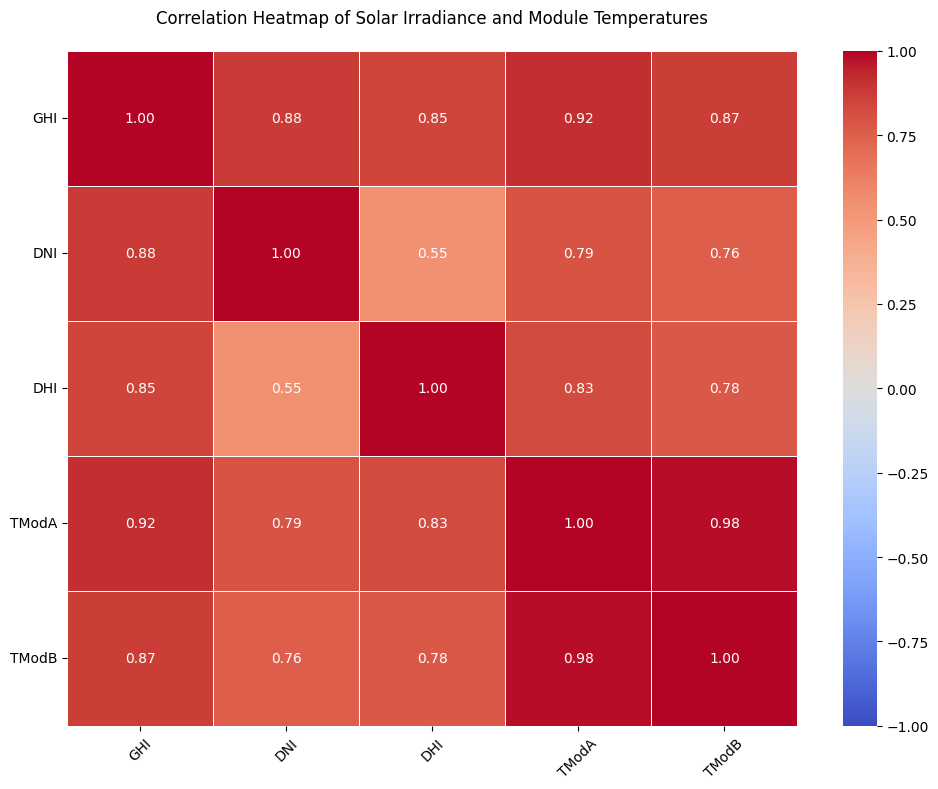

In [25]:
    # For heatmap

plt.figure(figsize=(10, 8))
corr = df[['GHI', 'DNI', 'DHI', 'TModA', 'TModB']].corr()

sns.heatmap(
    corr, 
    annot=True, 
    cmap='coolwarm', 
    vmin=-1, 
    vmax=1,
    fmt=".2f",          # Show 2 decimal places
    linewidths=0.5,      # Add cell borders
    annot_kws={"size": 10}  # Annotation font size
)

plt.title('Correlation Heatmap of Solar Irradiance and Module Temperatures', pad=20)
plt.xticks(rotation=45)  # Rotate x-labels
plt.yticks(rotation=0)   # Keep y-labels horizontal
plt.tight_layout()       # Prevent label cutoff

# Save the plot
plt.show

# Scatter plots

<function matplotlib.pyplot.show(close=None, block=None)>

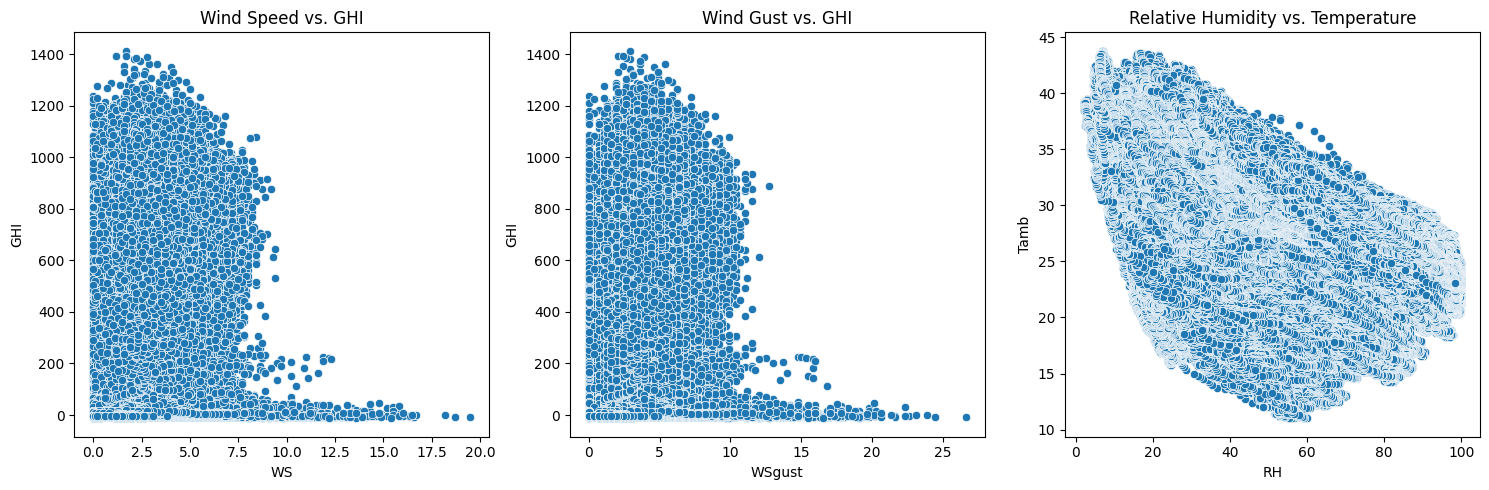

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.scatterplot(data=df, x='WS', y='GHI', ax=axes[0])
axes[0].set_title('Wind Speed vs. GHI')
sns.scatterplot(data=df, x='WSgust', y='GHI', ax=axes[1])
axes[1].set_title('Wind Gust vs. GHI')
sns.scatterplot(data=df, x='RH', y='Tamb', ax=axes[2])
axes[2].set_title('Relative Humidity vs. Temperature')
plt.tight_layout()
plt.show


# 6. Wind & Distribution Analysis
# Wind rose

<function matplotlib.pyplot.show(close=None, block=None)>

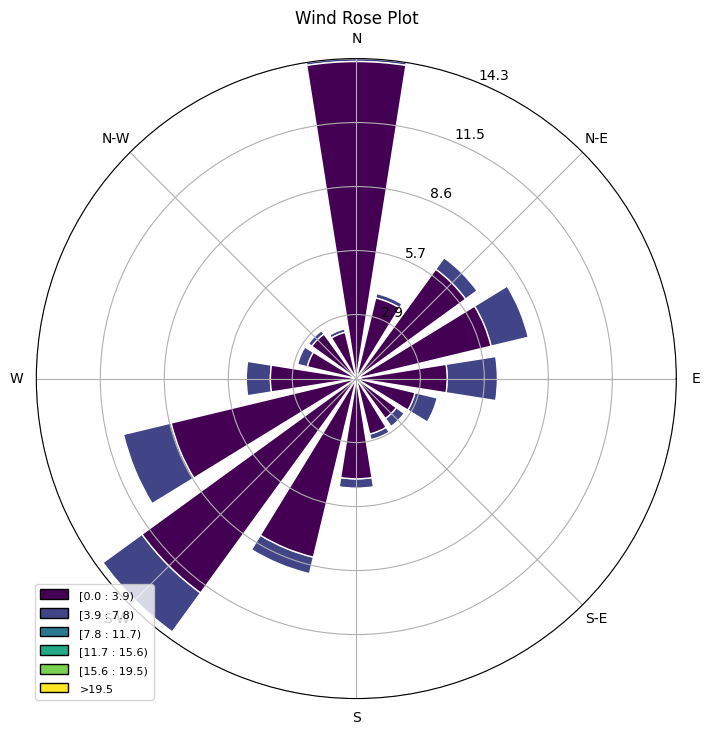

In [27]:
fig = plt.figure(figsize=(8, 8))
ax = WindroseAxes.from_ax(fig=fig)
ax.bar(df['WD'], df['WS'], normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
plt.title('Wind Rose Plot')
plt.show

# Histograms

<function matplotlib.pyplot.show(close=None, block=None)>

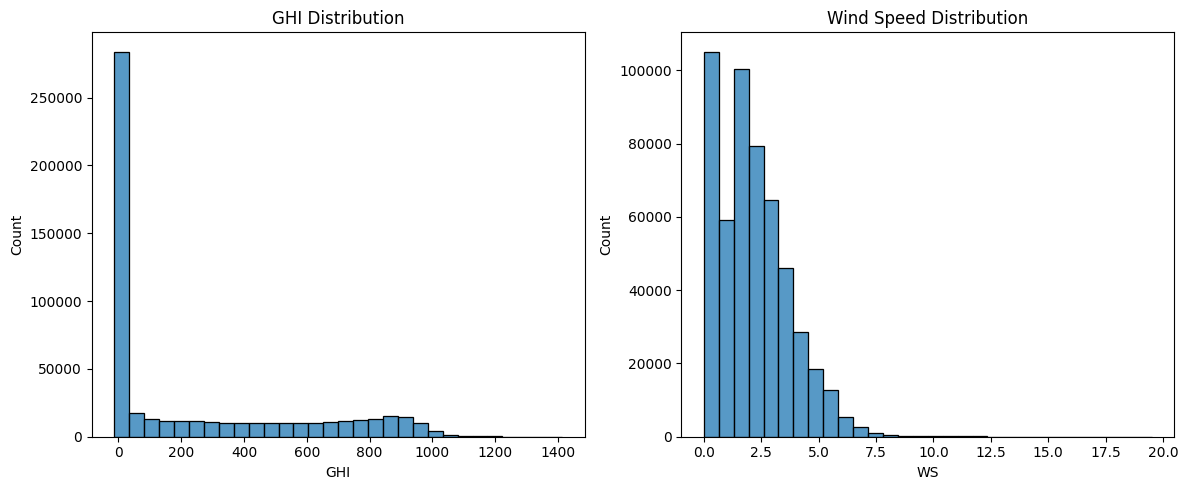

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df['GHI'], bins=30, ax=axes[0])
axes[0].set_title('GHI Distribution')
sns.histplot(df['WS'], bins=30, ax=axes[1])
axes[1].set_title('Wind Speed Distribution')
plt.tight_layout()
plt.show

# 7. Temperature Analysis

<function matplotlib.pyplot.show(close=None, block=None)>

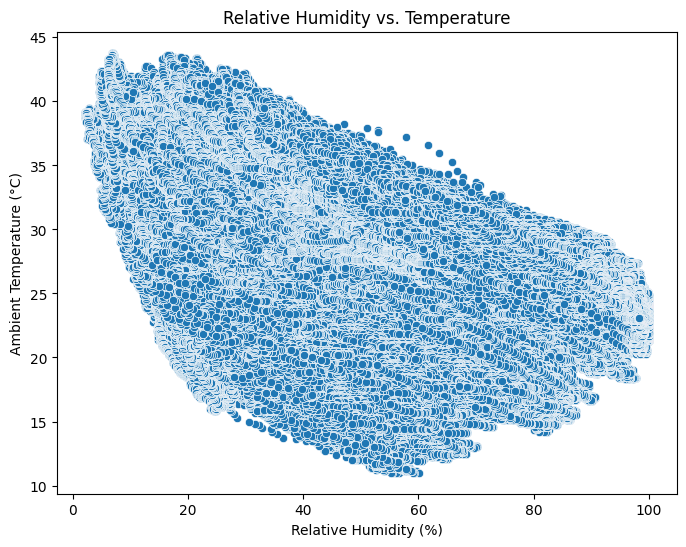

In [29]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='RH', y='Tamb')
plt.title('Relative Humidity vs. Temperature')
plt.xlabel('Relative Humidity (%)')
plt.ylabel('Ambient Temperature (°C)')
plt.show

# 8. Bubble Chart

<function matplotlib.pyplot.show(close=None, block=None)>

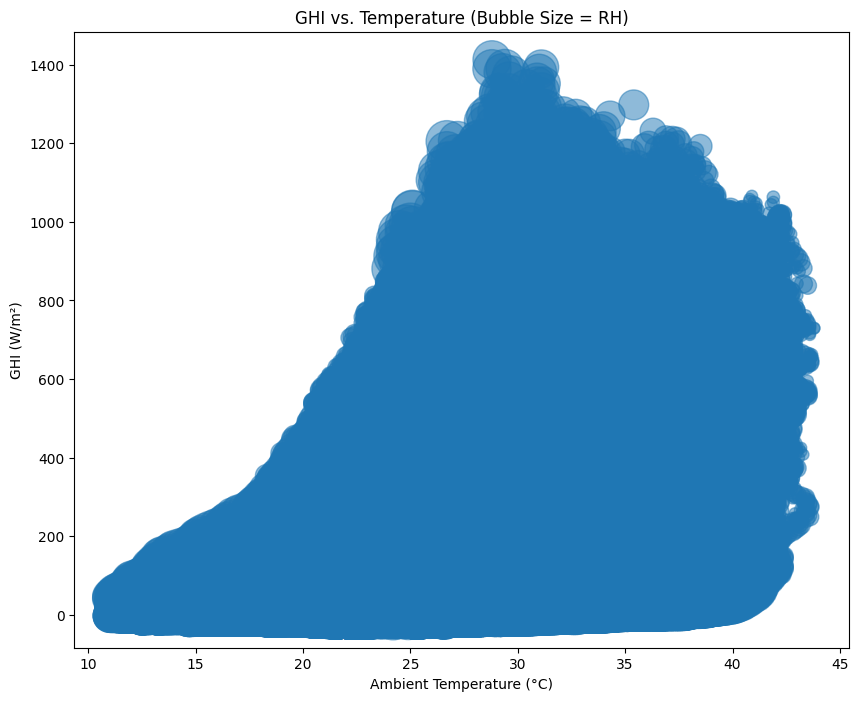

In [30]:
plt.figure(figsize=(10, 8))
plt.scatter(df['Tamb'], df['GHI'], s=df['RH']*10, alpha=0.5)
plt.title('GHI vs. Temperature (Bubble Size = RH)')
plt.xlabel('Ambient Temperature (°C)')
plt.ylabel('GHI (W/m²)')
plt.show

# 9. KPIs & References

In [32]:
print("\nKey Insights:")
print("- High correlation between GHI and DNI indicates consistent solar patterns.")
print("- Cleaning significantly improves ModA and ModB readings.")
print("- Wind speed and direction show seasonal patterns (wind rose).")
print("- RH inversely affects temperature, impacting solar efficiency.")

print("\nReferences:")
print("- Pandas Documentation: https://pandas.pydata.org/docs/")
print("- Seaborn Visualization: https://seaborn.pydata.org/")
print("- Windrose: https://windrose.readthedocs.io/")


Key Insights:
- High correlation between GHI and DNI indicates consistent solar patterns.
- Cleaning significantly improves ModA and ModB readings.
- Wind speed and direction show seasonal patterns (wind rose).
- RH inversely affects temperature, impacting solar efficiency.

References:
- Pandas Documentation: https://pandas.pydata.org/docs/
- Seaborn Visualization: https://seaborn.pydata.org/
- Windrose: https://windrose.readthedocs.io/
